Dataset saved to 'autonomous_vehicle_dataset.csv'.
Best parameters for navigation model: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Navigation model trained and saved.
Best parameters for safety model: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Safety model trained and saved.
Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.3151 - val_loss: 0.2517
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2531 - val_loss: 0.2517
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2519 - val_loss: 0.2513
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2512 - val_loss: 0.2509
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2513 - val_loss: 0.2512
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2503 - val_loss: 0.2507
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.2506 - val_loss: 0.2510
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss:

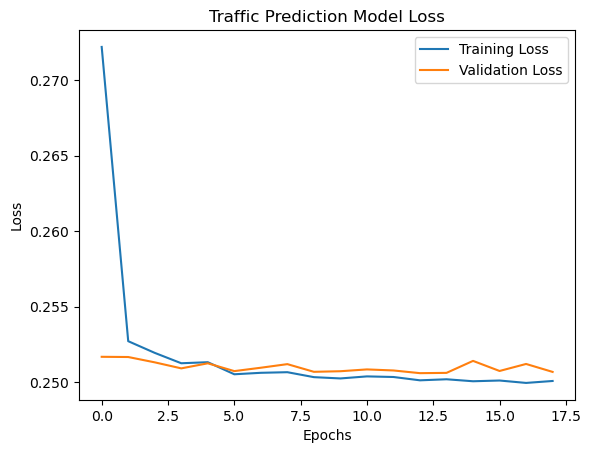

Traffic prediction model trained and saved.
Accuracy: 0.48875
Accuracy: 0.4855


In [1]:
# Autonomous Vehicles Project
# Enhancing Navigation, Traffic Prediction, and Safety

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import joblib

# Step 1: Load and prepare the dataset
def load_data():
    # Generating a sample dataset
    np.random.seed(42)
    data_size = 20000
    data = pd.DataFrame({
        'camera_input': np.random.rand(data_size),
        'lidar_input': np.random.rand(data_size),
        'radar_input': np.random.rand(data_size),
        'traffic_condition': np.random.randint(0, 2, size=data_size),
        'hazard_label': np.random.randint(0, 2, size=data_size)
    })
    # Save the dataset to a CSV file
    data.to_csv('autonomous_vehicle_dataset.csv', index=False)
    print("Dataset saved to 'autonomous_vehicle_dataset.csv'.")
    return data

# Step 2: Data Preprocessing
def preprocess_data(data):
    X = data[['camera_input', 'lidar_input', 'radar_input']]
    y_navigation = data['traffic_condition']
    y_safety = data['hazard_label']
    # Feature scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return train_test_split(X_scaled, y_navigation, y_safety, test_size=0.2, random_state=42)

# Step 3: Define and train models
## Navigation Model with Hyperparameter Tuning
def train_navigation_model(X_train, y_train):
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    model = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    joblib.dump(best_model, 'best_navigation_model.pkl')
    print(f"Best parameters for navigation model: {grid_search.best_params_}")
    return best_model

## Safety Model with Hyperparameter Tuning
def train_safety_model(X_train, y_train):
    param_grid = {
        'n_estimators': [100, 150, 200],
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
    model = GradientBoostingClassifier(random_state=42)
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    joblib.dump(best_model, 'best_safety_model.pkl')
    print(f"Best parameters for safety model: {grid_search.best_params_}")
    return best_model

## Traffic Prediction Model with Advanced Architecture
def train_traffic_model(X_train, y_train):
    model = Sequential([
        Input(shape=(X_train.shape[1], 1)),
        Bidirectional(LSTM(64, activation='relu', return_sequences=True)),
        Dropout(0.3),
        Bidirectional(LSTM(32, activation='relu')),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
    checkpoint = ModelCheckpoint('best_traffic_model.keras', save_best_only=True, monitor='val_loss', mode='min')
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=20, validation_split=0.2, batch_size=64, callbacks=[checkpoint, early_stopping])
    # Plot training history
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Traffic Prediction Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    return model

# Step 4: Evaluate models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    if hasattr(model, 'predict_proba'):
        accuracy = accuracy_score(y_test, y_pred)
        print(f'Accuracy: {accuracy}')
    else:
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        print(f'MSE: {mse}, MAE: {mae}')

# Step 5: Main Workflow
data = load_data()
X_train, X_test, y_nav_train, y_nav_test, y_safety_train, y_safety_test = preprocess_data(data)

# Train navigation model
navigation_model = train_navigation_model(X_train, y_nav_train)
print("Navigation model trained and saved.")

# Train safety model
safety_model = train_safety_model(X_train, y_safety_train)
print("Safety model trained and saved.")

# Traffic prediction requires reshaped data
X_train_traffic = np.expand_dims(X_train, axis=2)
traffic_model = train_traffic_model(X_train_traffic, y_nav_train)
print("Traffic prediction model trained and saved.")

# Evaluate models
evaluate_model(navigation_model, X_test, y_nav_test)
evaluate_model(safety_model, X_test, y_safety_test)
